Link to dataset: [Here](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes)

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Pretty display for notebooks
%matplotlib inline

# Load data and cleanup

In [ ]:
df_intakes = pd.read_csv('./data/aac_intakes.csv')
df_intakes_outcomes = pd.read_csv('./data/aac_intakes_outcomes.csv')
df_outcomes = pd.read_csv('./data/aac_outcomes.csv')

## Check dataframe shapes

In [ ]:
print("Intakes:\n\tLines: {}\n\tColumns: {}".format(df_intakes.shape[0], df_intakes.shape[1]))
print("Intakes_outcomes:\n\tLines: {}\n\tColumns: {}".format(df_intakes_outcomes.shape[0], df_intakes_outcomes.shape[1]))
print("Outcomes:\n\tLines: {}\n\tColumns: {}".format(df_outcomes.shape[0], df_outcomes.shape[1]))

## Check head content

### Intakes

In [ ]:
df_intakes.head(5)

## Intakes_outcomes

In [ ]:
df_intakes_outcomes.head(4)

### Outcomes

In [ ]:
df_outcomes.head(4)

### Clean data

In [ ]:
# Clean intakes
df_intakes.drop('datetime2', axis=1, inplace=True)
df_intakes.drop('found_location', axis=1, inplace=True)

# Clean intakes_outcomes
df_intakes_outcomes.drop('intake_month', axis=1, inplace=True)
df_intakes_outcomes.drop('intake_year', axis=1, inplace=True)
df_intakes_outcomes.drop('intake_monthyear', axis=1, inplace=True)
df_intakes_outcomes.drop('intake_weekday', axis=1, inplace=True)
df_intakes_outcomes.drop('intake_hour', axis=1, inplace=True)
df_intakes_outcomes.drop('time_in_shelter', axis=1, inplace=True)   #time_in_shelter_days is more usable

# Clean outcomes
df_outcomes.drop('monthyear', axis=1, inplace=True)


## Fetch dataset and create in & out dataframes

In [54]:
incomes_endpoint = 'https://data.austintexas.gov/resource/wter-evkm.json'
outcomes_endpoint = 'https://data.austintexas.gov/resource/9t4d-g238.json'

import requests
params = {'$limit': 10000000} # If not specified it only returns 1000 records
r = requests.get(incomes_endpoint, params)
in_df = pd.DataFrame(r.json())
r = requests.get(outcomes_endpoint, params)
out_df = pd.DataFrame(r.json())

in_df['income_time'] = pd.to_datetime(in_df['datetime'])
out_df['outcome_time'] = pd.to_datetime(out_df['datetime'])
out_df['date_of_birth'] = pd.to_datetime(out_df['date_of_birth'])

in_df.drop(['datetime','datetime2'], axis=1, inplace=True)
out_df.drop(['monthyear', 'datetime'], axis=1, inplace=True)

print('Incomes shape',in_df.shape)
print('Outcomes shape',out_df.shape)


Incomes shape (122787, 11)
Outcomes shape (122839, 11)


In [55]:
in_df.head(5)

,animal_id,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name,income_time
0,A827166,1520 Frontier Valley Drive in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Shorthair,Torbie,NaN,2020-12-15 11:09:00
1,A827164,Harris Ridge Blvd in Travis (TX),Stray,Normal,Dog,Intact Female,2 years,Mastiff,Brown Brindle,NaN,2020-12-15 08:04:00
2,A827161,4602 Borage in Austin (TX),Stray,Normal,Dog,Intact Male,4 years,Australian Shepherd/St. Bernard Smooth Coat,Black/White,NaN,2020-12-14 20:39:00
3,A827152,Old Manor Rd And 290 in Austin (TX),Stray,Normal,Dog,Intact Male,2 years,Labrador Retriever,Chocolate,NaN,2020-12-14 16:14:00
4,A827151,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,10 years,Domestic Shorthair,Torbie,Meko,2020-12-14 16:00:00


In [56]:
out_df.head(5)

,animal_id,name,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype,outcome_time
0,A821019,Spot,2017-04-03,Adoption,Dog,Neutered Male,3 years,Pit Bull,White/Black,NaN,2020-12-08 12:37:00
1,A824438,*Rose,2011-11-27,Adoption,Dog,Spayed Female,9 years,German Shepherd,Tan/Black,NaN,2020-12-08 12:27:00
2,A825587,*Ludwig,2011-11-06,Adoption,Cat,Neutered Male,9 years,Domestic Medium Hair,Cream Tabby,Foster,2020-12-08 12:22:00
3,A819626,NaN,2020-06-25,Adoption,Cat,Neutered Male,5 months,Domestic Shorthair,White/Black,Foster,2020-12-08 11:53:00
4,A819624,NaN,2020-06-25,Adoption,Cat,Neutered Male,5 months,Domestic Shorthair,Black,Foster,2020-12-08 11:52:00


## Create unique id to merge in & out datasets

In [57]:
def create_unique_id(df, event):
    df.reset_index(inplace=True)

    df[event + '_number'] = df.groupby(['animal_id'])[event + '_time'].rank(method='dense', ascending=False)
    df['animal_id_new'] = df['animal_id'] + '_' + df[event + '_number'].astype(int).astype(str)

    return df

In [58]:
in_df = create_unique_id(in_df, 'income')
out_df = create_unique_id(out_df, 'outcome')

## Check columns in common

In [61]:
print('Columns of the income ->',in_df.columns)
print('Columns of the outcome ->',out_df.columns)
set(in_df.columns).intersection(out_df.columns)

Columns of the income -> Index(['animal_id', 'found_location', 'intake_type', 'intake_condition',
       'animal_type', 'sex_upon_intake', 'age_upon_intake', 'breed', 'color',
       'name', 'income_time', 'income_number', 'animal_id_new'],
      dtype='object')
Columns of the outcome -> Index(['date_of_birth', 'outcome_type', 'sex_upon_outcome', 'age_upon_outcome',
       'outcome_subtype', 'outcome_time', 'outcome_number', 'animal_id_new'],
      dtype='object')


{'animal_id_new'}

## Remove columns to avoid duplicates in merge

In [ ]:
in_df.drop(['index'], axis=1, inplace=True)
out_df.drop(['index', 'animal_type', 'breed', 'color','name', 'animal_id'], axis=1, inplace=True)

#### Merge

In [62]:
in_df.set_index('animal_id_new', inplace=True)
out_df.set_index('animal_id_new', inplace=True)

in_out_df = pd.merge(out_df, in_df, how='inner', 
                  right_index=True, left_index=True, suffixes=['_outcome', '_intake'])

In [63]:
print(in_out_df.columns)
print('Income shape', in_df.shape)
print('Outcome shape', out_df.shape)
print('In/out shape', in_out_df.shape)
in_out_df.head()
# TODO: see why the diference in row numbers (animals with income but not yet an outcome?) 

Index(['date_of_birth', 'outcome_type', 'sex_upon_outcome', 'age_upon_outcome',
       'outcome_subtype', 'outcome_time', 'outcome_number', 'animal_id',
       'found_location', 'intake_type', 'intake_condition', 'animal_type',
       'sex_upon_intake', 'age_upon_intake', 'breed', 'color', 'name',
       'income_time', 'income_number'],
      dtype='object')
Income shape (122787, 12)
Outcome shape (122839, 7)
In/out shape (121834, 19)


,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome,outcome_subtype,outcome_time,outcome_number,animal_id,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name,income_time,income_number
animal_id_new,,,,,,,,,,,,,,,,,,,
A006100_1,2007-07-09,Return to Owner,Neutered Male,10 years,NaN,2017-12-07 00:00:00,1.0,A006100,Colony Creek And Hunters Trace in Austin (TX),Stray,Normal,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,Scamp,2017-12-07 14:07:00,1.0
A006100_2,2007-07-09,Return to Owner,Neutered Male,7 years,NaN,2014-12-20 16:35:00,2.0,A006100,8700 Research Blvd in Austin (TX),Public Assist,Normal,Dog,Neutered Male,7 years,Spinone Italiano Mix,Yellow/White,Scamp,2014-12-19 10:21:00,2.0
A006100_3,2007-07-09,Return to Owner,Neutered Male,6 years,NaN,2014-03-08 17:10:00,3.0,A006100,8700 Research in Austin (TX),Public Assist,Normal,Dog,Neutered Male,6 years,Spinone Italiano Mix,Yellow/White,Scamp,2014-03-07 14:26:00,3.0
A047759_1,2004-04-02,Transfer,Neutered Male,10 years,Partner,2014-04-07 15:12:00,1.0,A047759,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,10 years,Dachshund,Tricolor,Oreo,2014-04-02 15:55:00,1.0
A134067_1,1997-10-16,Return to Owner,Neutered Male,16 years,NaN,2013-11-16 11:54:00,1.0,A134067,12034 Research Blvd in Austin (TX),Public Assist,Injured,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,Bandit,2013-11-16 09:02:00,1.0


## Create column time in shelter using outcome and income times

In [92]:
in_out_df['time_in_shelter'] = in_out_df['outcome_time'] - in_out_df['income_time']

In [93]:
in_out_df['time_in_shelter'].describe()

count                     121815
mean     18 days 13:45:18.635636
std      49 days 09:34:39.491227
min              0 days 00:00:00
25%              1 days 06:31:00
50%              5 days 02:15:00
75%             15 days 01:13:00
max           2410 days 17:49:00
Name: time_in_shelter, dtype: object

### Check why the negative value in min

In [94]:
in_later = in_out_df[['income_time', 'outcome_time']][in_out_df['income_time'] > in_out_df['outcome_time']]

print(len(in_later))
in_later.head()

0


,income_time,outcome_time
animal_id_new,,


### Fix time (also possible to delete those rows)

In [95]:
in_out_df['income_time'], in_out_df['outcome_time'] = np.where(in_out_df['income_time'] > in_out_df['outcome_time'], [in_out_df['outcome_time'], in_out_df['income_time']],[in_out_df['income_time'], in_out_df['outcome_time']])

In [96]:
in_out_df['time_in_shelter'] = pd.to_datetime(in_out_df['outcome_time']) - pd.to_datetime(in_out_df['income_time'])
in_out_df['time_in_shelter'].describe()

count                     121815
mean     18 days 13:45:18.635636
std      49 days 09:34:39.491227
min              0 days 00:00:00
25%              1 days 06:31:00
50%              5 days 02:15:00
75%             15 days 01:13:00
max           2410 days 17:49:00
Name: time_in_shelter, dtype: object

# Analysis of the data

In [72]:
sns.set(style="white", context="talk", font_scale=1.2)

In [78]:
in_out_df['animal_type'].value_counts()

Dog      69051
Cat      45693
Other     6498
Bird       573
Name: animal_type, dtype: int64

### Remove Livestock type animals

In [77]:
in_out_df = in_out_df.loc[in_out_df['animal_type'] != 'Livestock']

### Top 10 intake to outcome cases

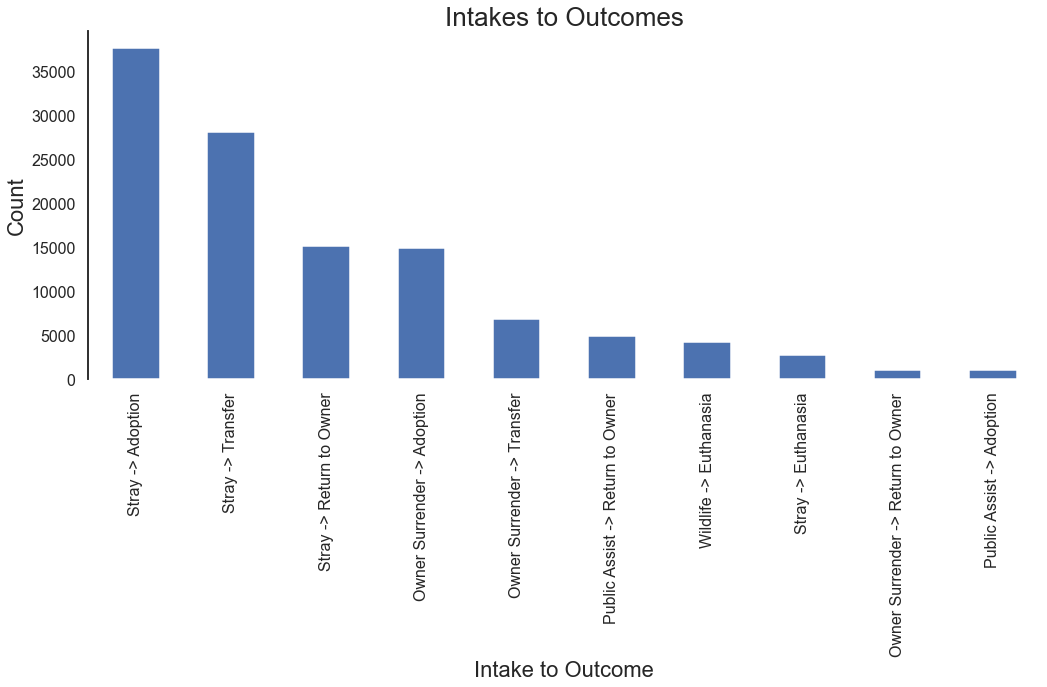

In [103]:
in_out_df['Intake_Outcome'] = in_out_df['intake_type'] + ' -> ' + in_out_df['outcome_type']

intake_outcomes = in_out_df['Intake_Outcome'].value_counts()[0:10].plot(kind='bar', 
                                                                     fontsize=16, 
                                                                     figsize=(15, 10))
intake_outcomes.set_ylabel('Count', fontsize=22)
intake_outcomes.set_xlabel('Intake to Outcome', fontsize=22)
intake_outcomes.set_title('Intakes to Outcomes', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

### This 10 groups describe the %95 of the dataset

In [105]:
for i in range(1, 10):
    print(in_out_df['Intake_Outcome'].value_counts()[0:i].sum() / in_out_df['Intake_Outcome'].value_counts().sum())

0.30883342911091044
0.539725802479271
0.6644199983580987
0.7872177982103276
0.8435432230522946
0.8841556522453
0.9189475412527707
0.9411953041622199
0.9499876857400871


##  Intakes and outcome results by the mean number of days in the shelter.

In [98]:
in_out_df['time_in_shelter'] = pd.to_timedelta(in_out_df['time_in_shelter'])
in_out_df['time_in_shelter_days'] = in_out_df['time_in_shelter'].dt.total_seconds() / (24 * 60 * 60)

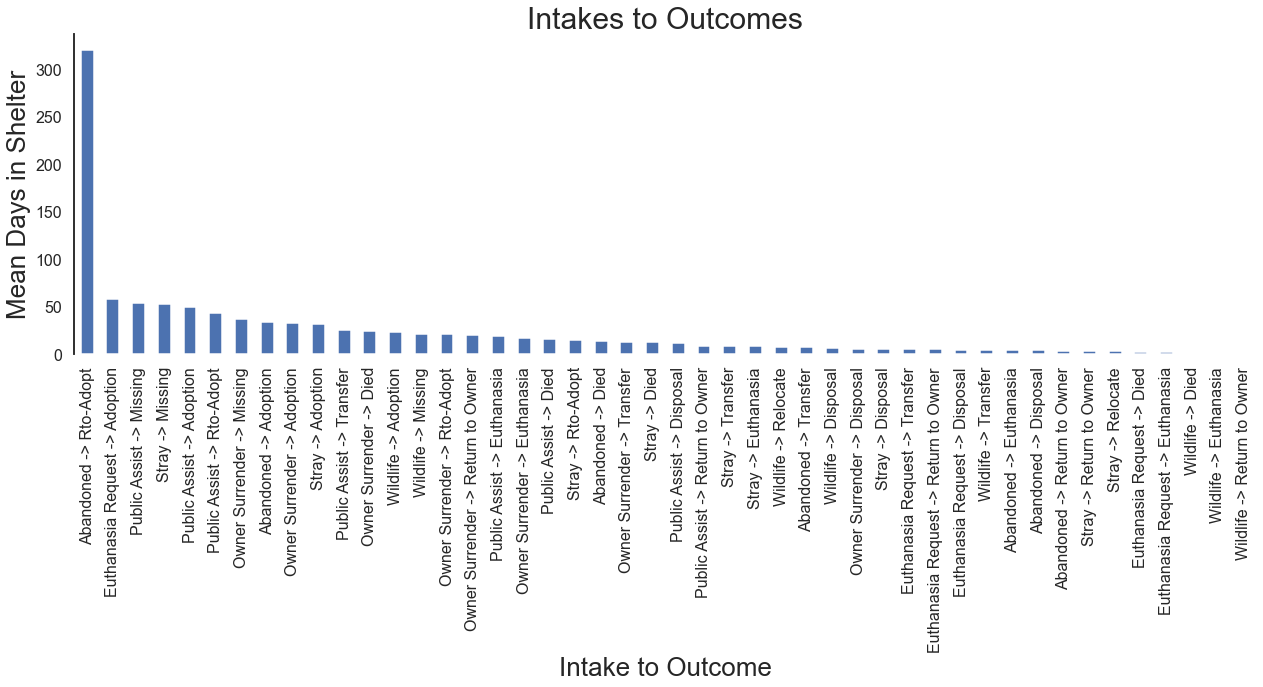

In [102]:
intake_outcome_days = in_out_df.groupby('Intake_Outcome')['time_in_shelter_days'].mean().sort_values(ascending=False).plot(kind='bar', 
                                                                                                                        fontsize=16, 
                                                                                                                        figsize=(18, 10))

intake_outcome_days.set_ylabel('Mean Days in Shelter', fontsize=26)
intake_outcome_days.set_xlabel('Intake to Outcome', fontsize=26)
intake_outcome_days.set_title('Intakes to Outcomes', fontsize=30)

plt.tight_layout()
sns.despine(bottom=True)